# Import Packages

In [3]:
import warnings
warnings.filterwarnings("ignore")

import utils
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

from tqdm.keras import TqdmCallback
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import confusion_matrix, mean_squared_error
import tensorflow as tf
import random as rn
import os

os.environ['PYTHONHASHSEED'] = '0'
np.random.seed(42)
rn.seed(12345)
tf.random.set_seed(1234)

from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Dense, Dropout, Activation, BatchNormalization, LSTM
from tensorflow.keras import optimizers, regularizers

# Rest of your code...


# Function Definition

# Import Data

In [10]:
df = pd.read_csv('../Dataset/crypto/BTCUSDT_data_prepared.csv')
# df=df.drop('Unnamed: 0',1)|
df=df[['Open','High','Low','Close','Volume','SMA_indicator','close_diff_Upper_Bollinger','close_diff_Lower_Bollinger','Bollinger_indicator','true_range','date','weekday','time','close_before_1','close_before_2','close_before_3','close_before_4','close_before_5','close_before_6','close_before_7','close_before_8','close_before_9']]
df=df[~(pd.isnull(df.close_before_9))]
df=df.reset_index(drop=True)

In [17]:
from tqdm.keras import TqdmCallback
import tensorflow as tf
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import confusion_matrix, mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dropout, LSTM, Dense, Activation
from tensorflow.keras import regularizers
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Your utility functions
import utils

def scale_data(df_train_raw, df_val_raw):
    scaler = MinMaxScaler(feature_range=(0, 1))
    df_train_scaled = scaler.fit_transform(df_train_raw)
    df_val_scaled = scaler.transform(df_val_raw)
    return df_train_scaled, df_val_scaled, scaler

def build_model(TIME_STEPS, input_shape, lstm_units_1, lstm_units_2, hidden_units_1, hidden_units_2, input_dropout, hidden_dropout, l2_regularizer):
    model = Sequential()
    model.add(Input(batch_input_shape=(None, TIME_STEPS, input_shape)))
    model.add(Dropout(input_dropout))
    model.add(LSTM(units=lstm_units_1, return_sequences=True, kernel_initializer='random_uniform'))
    model.add(Dropout(hidden_dropout))
    model.add(LSTM(units=lstm_units_2))
    model.add(Dropout(hidden_dropout))
    model.add(Dense(hidden_units_1, kernel_regularizer=regularizers.l2(l2_regularizer), activity_regularizer=regularizers.l2(l2_regularizer)))
    model.add(Activation('relu'))
    model.add(Dropout(hidden_dropout))
    model.add(Dense(hidden_units_2, kernel_regularizer=regularizers.l2(l2_regularizer), activity_regularizer=regularizers.l2(l2_regularizer)))
    model.add(Activation('relu'))
    model.add(Dropout(hidden_dropout))
    model.add(Dense(1))
    return model

def train_model(model, x_train, y_train, x_val, y_val, BATCH_SIZE, epochs, optimizer):
    model.compile(loss='mean_squared_error', optimizer=optimizer, metrics=['mape'])
    history = model.fit(x_train, y_train,
                        batch_size=BATCH_SIZE,
                        epochs=epochs,
                        verbose=0,
                        validation_data=(x_val, y_val),
                        callbacks=[TqdmCallback(verbose=1)])
    return history

def predict(model, x_val, BATCH_SIZE):
    y_pred = model.predict(x_val, batch_size=BATCH_SIZE)
    return y_pred.flatten()

def evaluate_predictions(y_pred, y_val, scaler):
    y_pred_org = (y_pred * scaler.data_range_[3]) + scaler.data_min_[3]
    y_val_org = (y_val * scaler.data_range_[3]) + scaler.data_min_[3]
    return y_pred_org, y_val_org

def calculate_accuracy(y_true, y_pred, window=7):
    y_pred_after = y_pred[window:]
    y_pred_before = y_pred[:-window]
    is_bullish_pred = (pd.Series(y_pred_after) - pd.Series(y_pred_before)).apply(lambda x: 1 if x > 0 else 0)

    y_true_after = y_true[window:]
    y_true_before = y_true[:-window]
    is_bullish_true = (pd.Series(y_true_after) - pd.Series(y_true_before)).apply(lambda x: 1 if x > 0 else 0)

    confusion = confusion_matrix(is_bullish_true, is_bullish_pred)
    acc = (confusion[0][0] + confusion[1][1]) / np.sum(confusion)
    return acc

def plot_results(history, y_pred_org, y_val_org):
    # Plot training & validation loss values
    plt.figure()
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Val'], loc='upper left')
    plt.show()

    # Plot Prediction Result
    plt.figure()
    plt.plot(y_pred_org)
    plt.plot(y_val_org)
    plt.title('Prediction vs Real Asset Price')
    plt.ylabel('Price ($)')
    plt.xlabel('Timesteps')
    plt.legend(['Prediction', 'Real'], loc='upper left')
    plt.show()

def cross_val(df, TIME_STEPS, BATCH_SIZE, n_fold, input_dropout, hidden_dropout, l2_regularizer, lstm_units_1, lstm_units_2, hidden_units_1, hidden_units_2, optimizer, epochs):
    tscv = TimeSeriesSplit(n_splits=n_fold)
    mape_list, adj_mape_list, acc_list = [], [], []

    for train_index, val_index in tscv.split(df):
        print("#Train Samples: ", len(train_index), "#Val Samples: ", len(val_index))
        df_train_raw, df_val_raw = df.loc[train_index,:], df.loc[val_index,:]

        df_train_scaled, df_val_scaled, scaler = scale_data(df_train_raw, df_val_raw)
        x_train, y_train = utils.build_timeseries(df_train_scaled, 3, TIME_STEPS)
        x_val, y_val = utils.build_timeseries(df_val_scaled, 3, TIME_STEPS)
        x_train, y_train = utils.trim_dataset(x_train, BATCH_SIZE), utils.trim_dataset(y_train, BATCH_SIZE)
        x_val, y_val = utils.trim_dataset(x_val, BATCH_SIZE), utils.trim_dataset(y_val, BATCH_SIZE)

        model = build_model(TIME_STEPS, x_train.shape[2], lstm_units_1, lstm_units_2, hidden_units_1, hidden_units_2, input_dropout, hidden_dropout, l2_regularizer)
        history = train_model(model, x_train, y_train, x_val, y_val, BATCH_SIZE, epochs, optimizer)
        y_pred = predict(model, x_val, BATCH_SIZE)
        y_pred_org, y_val_org = evaluate_predictions(y_pred, y_val, scaler)

        # Calculate MAPE and Adjusted MAPE
        MAPE = utils.mape(y_val_org, y_pred_org)
        mape_list.append(MAPE)
        print('Val MAPE: ', MAPE)

        adj_MAPE = utils.adjusted_mape(y_val_org, y_pred_org)
        adj_mape_list.append(adj_MAPE)
        print('Val Adjusted MAPE: ', adj_MAPE)

        # Calculate accuracy
        acc = calculate_accuracy(y_val_org, y_pred_org)
        acc_list.append(acc)
        print('Val Accuracy: ', acc)

        # Plot results
        plot_results(history, y_pred_org, y_val_org)

    print('10-Fold Accuracy Test Avg Score: {}, Std Score: {}'.format(np.mean(acc_list), np.std(acc_list)))
    print('10-Fold MAPE Test Avg Score: {}, Std Score: {}'.format(np.mean(mape_list), np.std(mape_list)))
    print('10-Fold Adjusted MAPE Test Avg Score: {}, Std Score: {}'.format(np.mean(adj_mape_list), np.std(adj_mape_list)))
    print('Epochs: {}'.format(epochs))
    print('LSTM Nodes 1: {}'.format(lstm_units_1))
    print('LSTM Nodes 2: {}'.format(lstm_units_2))
    print('Input Dropout Rate: {}'.format(input_dropout))
    print('Hidden Dropout Rate: {}'.format(hidden_dropout))
    print('Optimizer: {}'.format(optimizer))

# Note: Ensure 'utils' module is properly defined with required functions like 'build_timeseries', 'trim_dataset', 'mape', and 'adjusted_mape'.


In [18]:
df

,Open,High,Low,Close,Volume,SMA_indicator,close_diff_Upper_Bollinger,close_diff_Lower_Bollinger,Bollinger_indicator,true_range,...,time,close_before_1,close_before_2,close_before_3,close_before_4,close_before_5,close_before_6,close_before_7,close_before_8,close_before_9
0,4411.00,4459.00,4411.00,4459.00,31.312436,0,-48.499549,194.403549,2.0,48.00,...,7,4411.00,4427.30,4460.00,4444.00,4360.69,4349.99,4324.35,4315.32,4308.83
1,4459.00,4485.39,4435.93,4470.82,51.735897,0,-48.984646,203.115555,2.0,49.46,...,7,4459.00,4411.00,4427.30,4460.00,4444.00,4360.69,4349.99,4324.35,4315.32
2,4470.82,4470.82,4333.42,4352.34,68.481270,0,-160.502832,84.576165,3.0,137.40,...,7,4470.82,4459.00,4411.00,4427.30,4460.00,4444.00,4360.69,4349.99,4324.35
3,4352.33,4354.35,4255.30,4354.18,67.458791,0,-152.366074,85.676843,3.0,99.05,...,7,4352.34,4470.82,4459.00,4411.00,4427.30,4460.00,4444.00,4360.69,4349.99
4,4354.18,4354.84,4235.45,4289.24,59.664912,0,-217.106920,34.578348,3.0,119.39,...,7,4354.18,4352.34,4470.82,4459.00,4411.00,4427.30,4460.00,4444.00,4360.69
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
55817,43346.67,43753.15,43250.00,43676.07,2649.806700,0,117.920659,1192.854341,1.0,503.15,...,7,43346.68,43378.12,43176.32,43073.26,43007.74,42849.66,42763.08,43155.46,43183.74
55818,43676.07,44329.99,43608.00,44051.10,5051.478740,1,285.176673,1630.215327,1.0,721.99,...,7,43676.07,43346.68,43378.12,43176.32,43073.26,43007.74,42849.66,42763.08,43155.46
55819,44051.10,44134.80,43777.86,43915.71,2764.450380,1,20.668716,1504.474284,1.0,356.94,...,7,44051.10,43676.07,43346.68,43378.12,43176.32,43073.26,43007.74,42849.66,42763.08
55820,43915.70,44225.75,43827.69,43990.01,2510.891880,1,-37.771456,1604.275456,2.0,398.06,...,7,43915.71,44051.10,43676.07,43346.68,43378.12,43176.32,43073.26,43007.74,42849.66


## Hyperparameter Tuning

#Train Samples:  5082 #Val Samples:  5074


202/202 [==============================] - 2s 6ms/step
Val MAPE:  1.3940349991558247
Val Adjusted MAPE:  1.0666938051951365
Val Accuracy:  0.7713662502478683


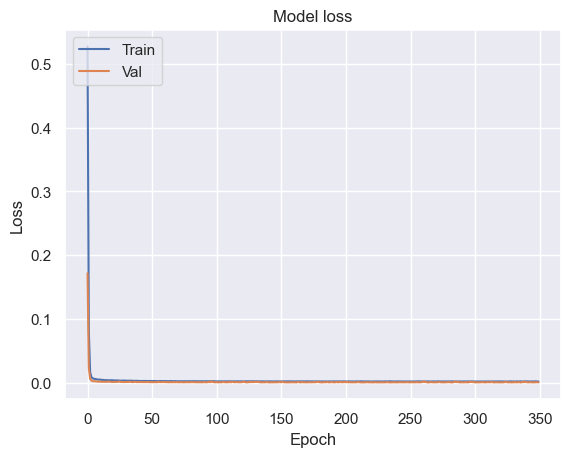

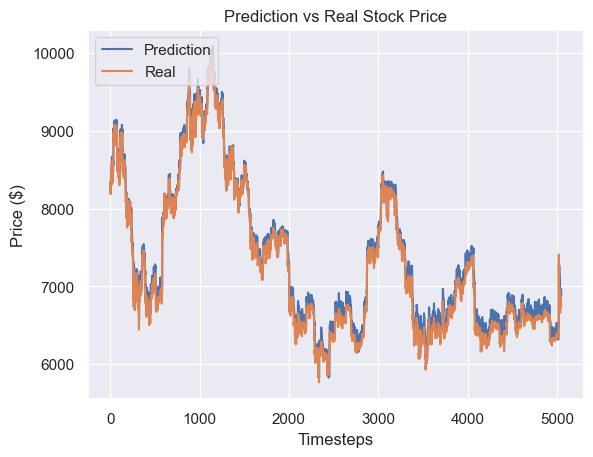

#Train Samples:  10156 #Val Samples:  5074


202/202 [==============================] - 2s 6ms/step
Val MAPE:  5.558630242250684
Val Adjusted MAPE:  4.327974760315303
Val Accuracy:  0.7404322823716042


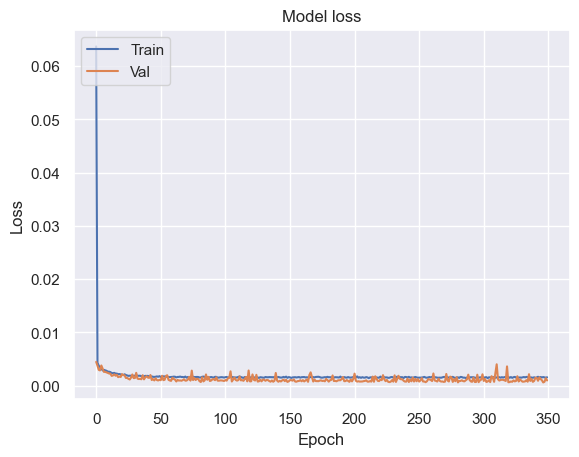

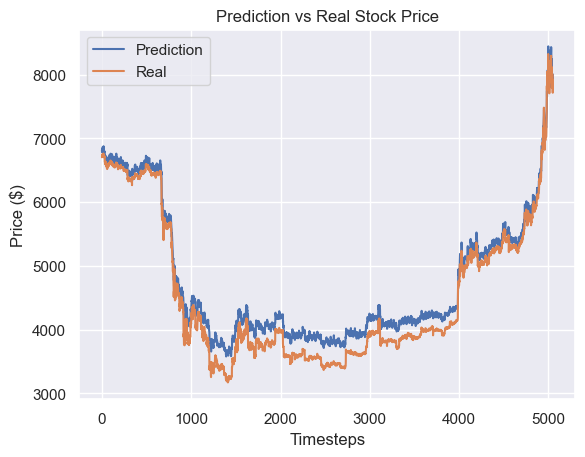

#Train Samples:  15230 #Val Samples:  5074


100%|██████████| 350/350 [53:44<00:00,  9.21s/epoch, loss=0.00153, mape=886, val_loss=0.000657, val_mape=3.12]    


202/202 [==============================] - 2s 7ms/step
Val MAPE:  2.024956587235161
Val Adjusted MAPE:  1.5718469197538498
Val Accuracy:  0.7763236168947055


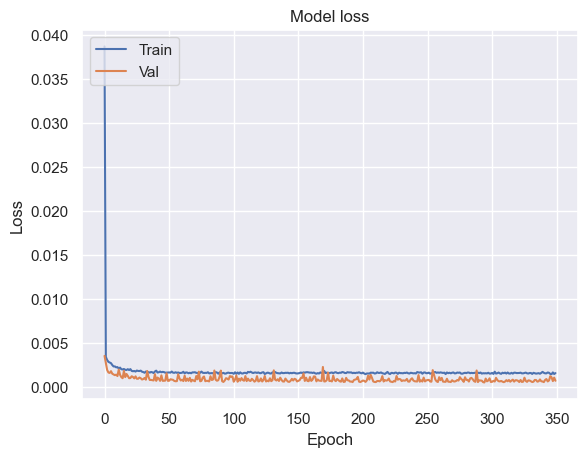

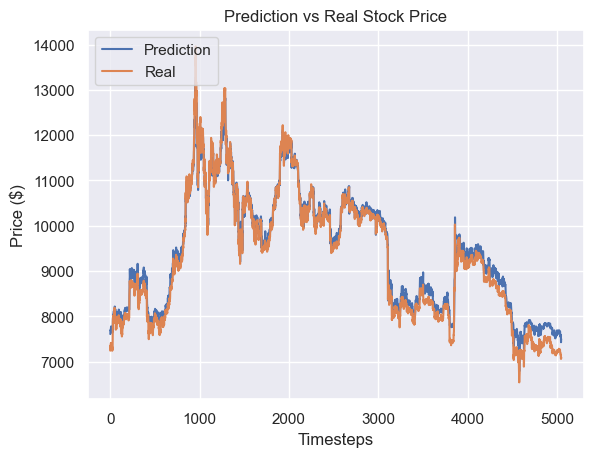

#Train Samples:  20304 #Val Samples:  5074


100%|██████████| 350/350 [1:09:28<00:00, 11.91s/epoch, loss=0.00145, mape=2.8e+3, val_loss=0.000497, val_mape=3.04] 


202/202 [==============================] - 2s 6ms/step
Val MAPE:  1.8119945451734436
Val Adjusted MAPE:  1.3944292730836547
Val Accuracy:  0.7816775728732898


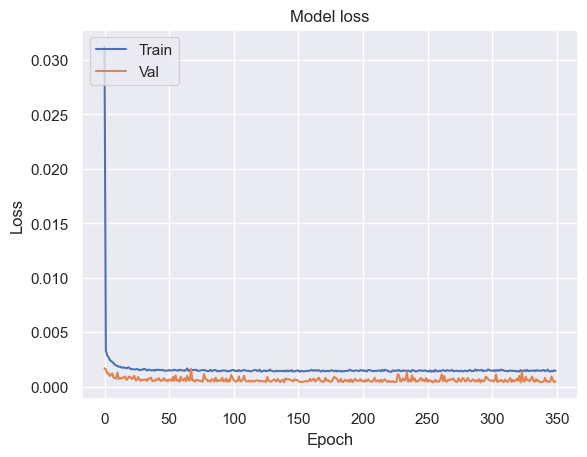

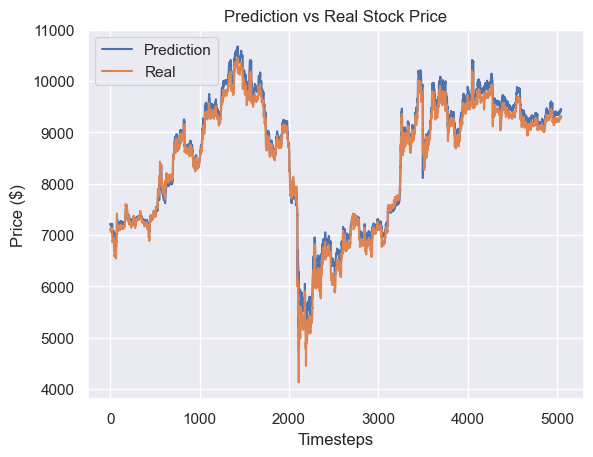

#Train Samples:  25378 #Val Samples:  5074


100%|██████████| 350/350 [1:23:04<00:00, 14.24s/epoch, loss=0.00135, mape=1.54e+3, val_loss=0.162, val_mape=13.2] 


202/202 [==============================] - 2s 6ms/step
Val MAPE:  11.618066785549953
Val Adjusted MAPE:  8.944681381253584
Val Accuracy:  0.759865159627206


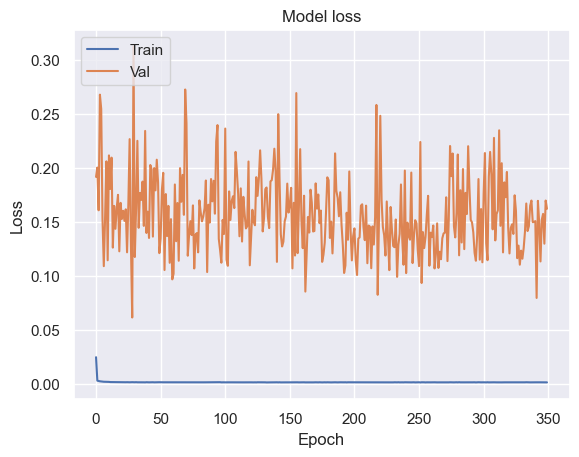

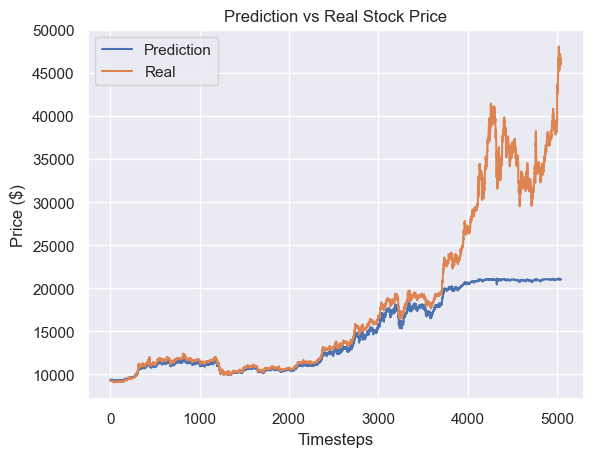

#Train Samples:  30452 #Val Samples:  5074


100%|██████████| 350/350 [1:38:48<00:00, 16.94s/epoch, loss=0.0012, mape=1.4e+3, val_loss=0.00781, val_mape=6.36]  


202/202 [==============================] - 2s 6ms/step
Val MAPE:  5.967126619365544
Val Adjusted MAPE:  4.527085271249103
Val Accuracy:  0.7459845330160618


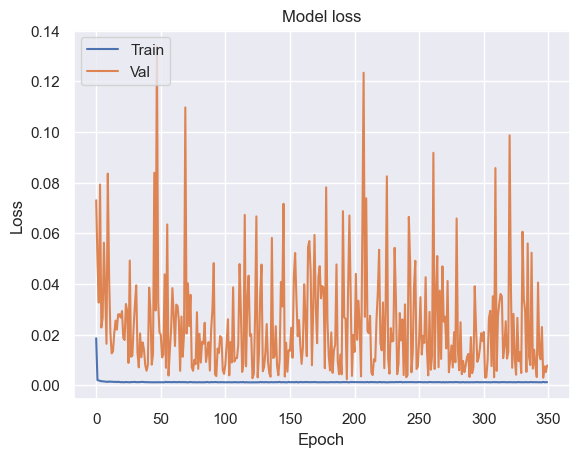

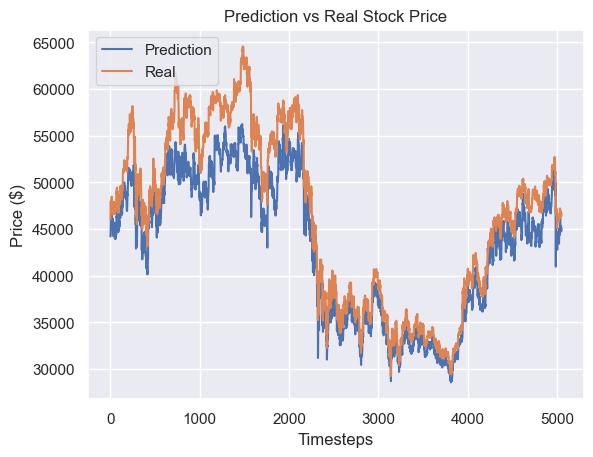

#Train Samples:  35526 #Val Samples:  5074


100%|██████████| 350/350 [2:00:33<00:00, 20.67s/epoch, loss=0.00189, mape=781, val_loss=0.0027, val_mape=5.52]       


202/202 [==============================] - 2s 6ms/step
Val MAPE:  5.17280199137105
Val Adjusted MAPE:  3.9852415504907026
Val Accuracy:  0.761054927622447


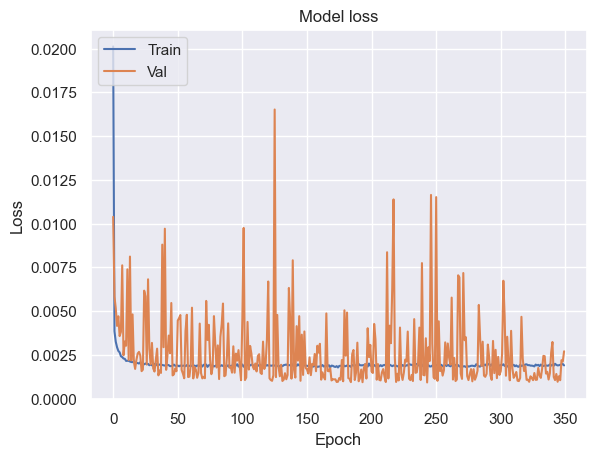

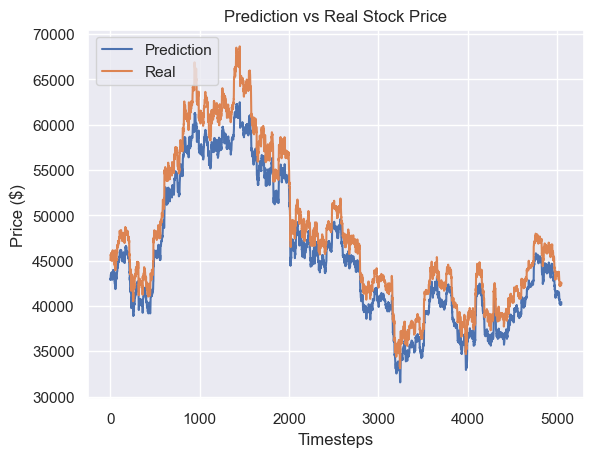

#Train Samples:  40600 #Val Samples:  5074


100%|██████████| 350/350 [2:29:19<00:00, 25.60s/epoch, loss=0.00191, mape=714, val_loss=0.000566, val_mape=1.54]      


202/202 [==============================] - 3s 7ms/step
Val MAPE:  1.3425249754399782
Val Adjusted MAPE:  1.0008638071425113
Val Accuracy:  0.6956176878841959


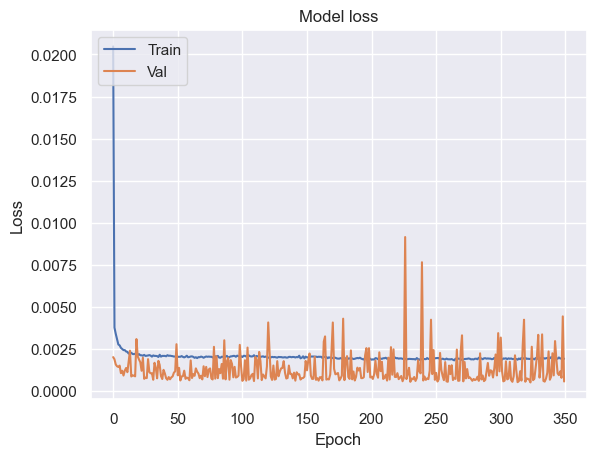

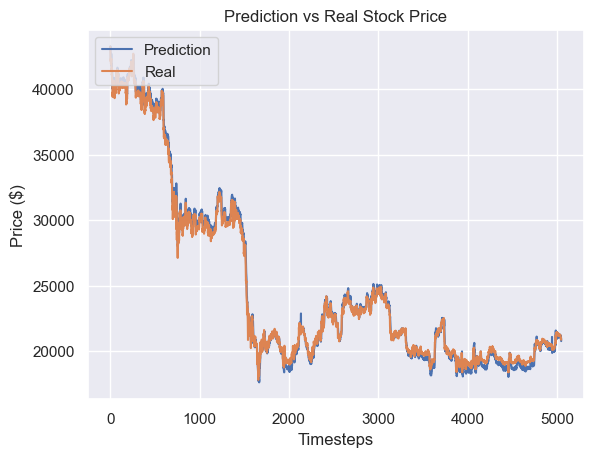

#Train Samples:  45674 #Val Samples:  5074


100%|██████████| 350/350 [2:45:19<00:00, 28.34s/epoch, loss=0.00195, mape=911, val_loss=0.00133, val_mape=8.56]       


202/202 [==============================] - 3s 8ms/step
Val MAPE:  7.411222939473529
Val Adjusted MAPE:  5.639442549849787
Val Accuracy:  0.7309141384096768


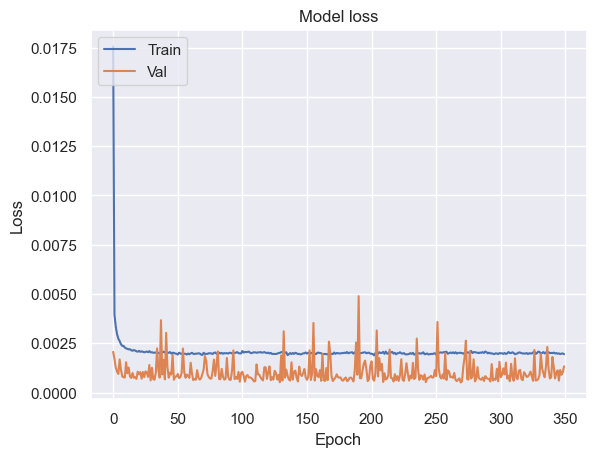

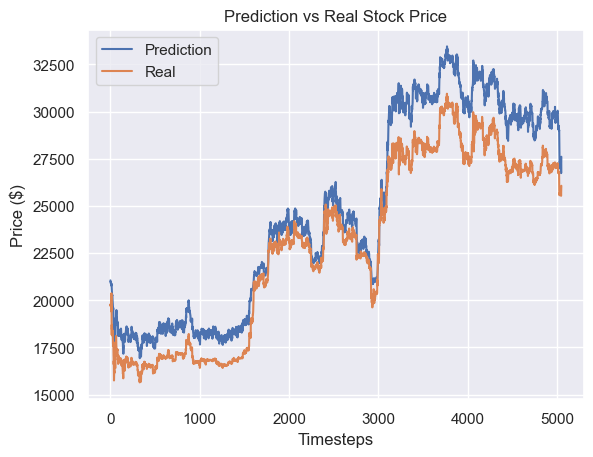

#Train Samples:  50748 #Val Samples:  5074


 65%|██████▍   | 227/350 [2:31:33<1:20:36, 39.32s/epoch, loss=0.00194, mape=1.08e+3, val_loss=0.000757, val_mape=2.01]

In [19]:
cross_val(df,TIME_STEPS=7,BATCH_SIZE=25,n_fold=10,
          input_dropout=0,hidden_dropout=0.2,l2_regularizer=0.005,
          lstm_units_1=256,lstm_units_2=128,
          hidden_units_1=128,hidden_units_2=64,
          optimizer=tf.keras.optimizers.tlegacy.Adam(learning_rate=0.0005),
          epochs=350)